# Datatonic OpenLibrary Coding Challenge
## What makes a great book in OpenLibrary? 📚

**Specifically: *What features contribute to the reading preferences of OpenLibrary's users?*** 

**Scoping and Assumptions:**
*Query Scope*
- I will be limiting my query to works that have **at least one readinglog_count**.
- I will initially limit the **first_publish_year to 2019** to run through my operations on a limited dataset before building it out to multiple years

*Measures of popularity and preference*
- I will be using **readinglog_count** and **rating** as the outcome measures.
  - Its important to note that readinglog_count does not indicate the number of times that a book has been borrowed through OpenLibrary, but is a sum of the user-entered fields *want_to_read_count, currently_reading_count,* and *already_read_count*. This means it is not the perfect measure of popularity of a book - ideally we'd use data from the borrowing log, or page clicks. I reached out to the OpenLibrary program manager 'Mek' (Michael...) however he confirmed this data was not available to the public. So we'll have to rely on this for now.

*Features under consideration*
- The following features are being considered to determine which factors are the best predictors (and therefore make the greatest contribution) to the popularity and rating of books for OpenLibrary's users.
  - 'first_publish_year, title, author_name, language, number_of_pages_median,publisher, format, subject, ratings_average, ratings_sortable, ratings_count, readinglog_count, want_to_read_count, currently_reading_count, already_read_count, first_sentence',


In [3]:
"""
Step 1. Construct and Convert the Query with Luqum (to be readable by apache solr, the query type specified in OpenLibrary's documentation)
"""
from luqum.parser import parser
from luqum.pretty import prettify
from luqum.tree import Word, Range

# Create a query for books first published in 2019 and with readinglog_count > 0
query = parser.parse('first_publish_year:2019 AND readinglog_count:[1 TO *]')

# Convert the query to a Solr query string
solr_query = prettify(query)
print(solr_query)

first_publish_year: 2019 AND readinglog_count: [1 TO *]


In [17]:
%%time
"""
Step 2. Make API Call
"""
import requests

# OpenLibrary API endpoint
url = 'http://openlibrary.org/search.json'

# Query parameters
params = {
    'q': solr_query,
    'sort': 'random',
    'fields': 'first_publish_year,title,author_name,language,number_of_pages_median,publisher,format,subject,ratings_average,ratings_sortable,ratings_count,readinglog_count,want_to_read_count,currently_reading_count,already_read_count,first_sentence',
    'limit': 1000  # Limit sample of results
}

# Make the API call
response = requests.get(url, params=params)

# Process the response
if response.status_code == 200:
    data = response.json()
    #for book in data.get('docs', []):
        #print(book)
else:
    print(f"Error: {response.status_code}")

data

CPU times: user 12.1 ms, sys: 3.78 ms, total: 15.8 ms
Wall time: 1.07 s


{'numFound': 49114,
 'start': 0,
 'numFoundExact': True,
 'docs': [{'author_name': ['Jenily Publishing'],
   'first_publish_year': 2019,
   'format': ['paperback'],
   'number_of_pages_median': 115,
   'publisher': ['Independently published', 'Independently Published'],
   'title': 'My Essential Oil Recipe Book',
   'readinglog_count': 1,
   'want_to_read_count': 1,
   'currently_reading_count': 0,
   'already_read_count': 0},
  {'author_name': ['Gavin Baddeley',
    'Neil Marshall',
    'Axelle Carolyn',
    'Andy Nyman'],
   'first_publish_year': 2019,
   'language': ['eng'],
   'number_of_pages_median': 240,
   'publisher': ['FAB Press'],
   'title': 'FrightFest Guide to Werewolf Movies',
   'subject': ['Literature'],
   'readinglog_count': 2,
   'want_to_read_count': 2,
   'currently_reading_count': 0,
   'already_read_count': 0},
  {'author_name': ['Oronzo Cilli'],
   'first_publish_year': 2019,
   'format': ['paperback'],
   'number_of_pages_median': 466,
   'publisher': ['Luna P

In [5]:
"""
Step 3. Load dataset into Pandas DataFrame and perform initial data overview
"""

import pandas as pd

data_df = pd.DataFrame.from_records(data['docs'])
data_df.head()

,author_name,first_publish_year,language,publisher,title,readinglog_count,want_to_read_count,currently_reading_count,already_read_count,format,number_of_pages_median,subject,ratings_average,ratings_sortable,ratings_count,first_sentence
0,[Cassie Cole],2019,[eng],[Independently Published],Proposition,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[Christina Baillie, Martha Baillie, Stan Dragl...",2019,NaN,[Pedlar Press],Sister Language,1,1,0,0,[paperback],218.0,NaN,NaN,NaN,NaN,NaN
2,[Nanddeep Nachan],2019,[eng],"[Bpb Publications, BPB Publications]",Mastering Sharepoint Framework,3,3,0,0,NaN,654.0,NaN,NaN,NaN,NaN,NaN
3,[Cameron Dezen Hammon],2019,NaN,[Lookout Books],This Is My Body,1,1,0,0,[paperback],224.0,"[Singers, united states, Musicians, biography,...",NaN,NaN,NaN,NaN
4,[Crystal Moon],2019,[eng],[Independently Published],Wicca Book of Shadows,2,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data_df.dtypes

author_name                 object
first_publish_year           int64
language                    object
publisher                   object
title                       object
readinglog_count             int64
want_to_read_count           int64
currently_reading_count      int64
already_read_count           int64
format                      object
number_of_pages_median     float64
subject                     object
ratings_average            float64
ratings_sortable           float64
ratings_count              float64
first_sentence              object
dtype: object

Text(0.5, 0.98, 'Plotting outcomes of interest')

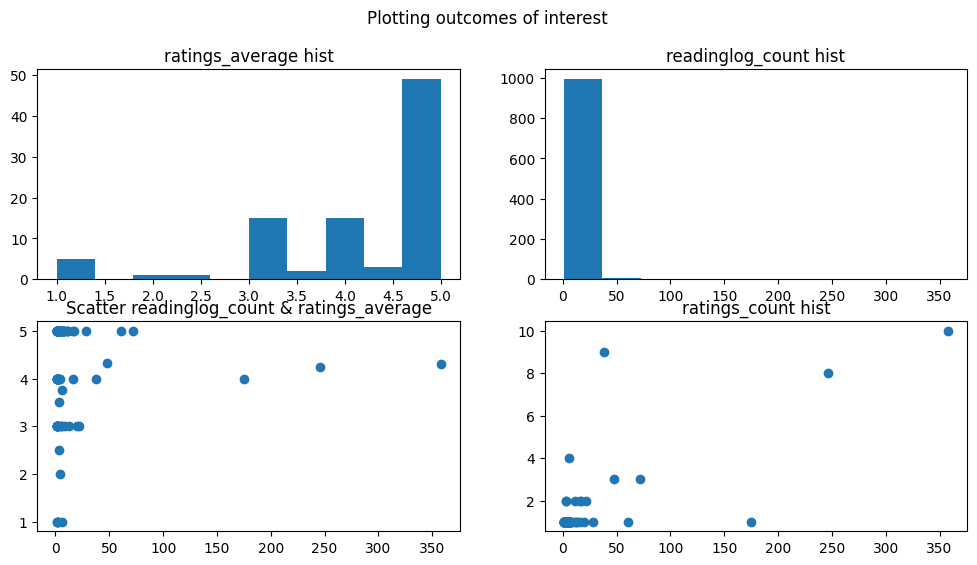

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
axs[0,0].set_title('ratings_average hist')
axs[0,0].hist(data_df['ratings_average'])
axs[0,1].set_title('readinglog_count hist')
axs[0,1].hist(data_df['readinglog_count'])
axs[1,0].set_title('Scatter readinglog_count & ratings_average')
axs[1,0].scatter(data_df['readinglog_count'], data_df['ratings_average'])
axs[1,1].set_title('ratings_count hist')
axs[1,1].scatter(data_df['readinglog_count'], data_df['ratings_count'])
fig.suptitle('Plotting outcomes of interest')


A quick look at the relationship between our two outcomes of interest, readinglog_count and ratings_average, appears to tell us the following:
- The 

(array([ 5.,  1.,  2., 29., 45.,  0.,  5.,  0.,  1.,  3.]),
 array([1.736997  , 1.88629687, 2.03559674, 2.18489661, 2.33419648,
        2.48349635, 2.63279622, 2.78209609, 2.93139596, 3.08069583,
        3.2299957 ]),
 <BarContainer object of 10 artists>)

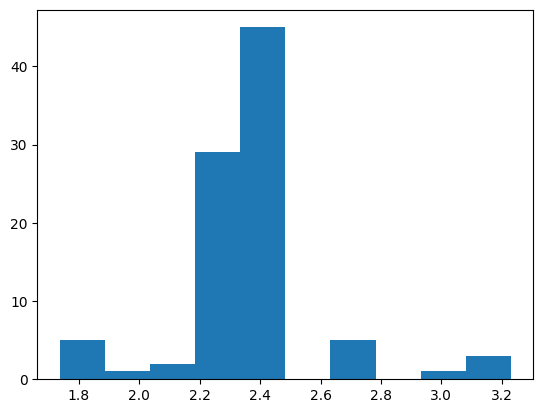

In [8]:
plt.hist(data_df['ratings_sortable'])


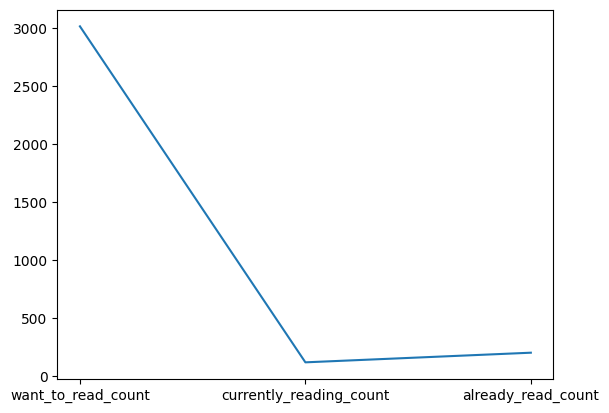

In [29]:
labels = ['want_to_read_count', 'currently_reading_count', 'already_read_count']
sums = []
for label in labels:
    sums.append(data_df[label].sum())

#reading_log_data = {'want_to_read_count' : data_df.['want_to_read_count'].sum(),'currently_reading_count': data_df.['currently_reading_count'].sum() ,'already_read_count': data_df['already_read_count'].sum()}
plt.plot(labels, data)

Let's clean up the data that we queried for further analysis:
- Null data
- Duplicates
- Outliers
- Scaling Numerical features
- Balancing
- Encoding categorical features

In [9]:
# Check for missing / null data
data_df.isnull().sum().sort_values(ascending=False) / len(data_df)

first_sentence             0.998
ratings_average            0.909
ratings_sortable           0.909
ratings_count              0.909
subject                    0.587
format                     0.529
language                   0.346
number_of_pages_median     0.289
author_name                0.014
publisher                  0.001
first_publish_year         0.000
title                      0.000
readinglog_count           0.000
want_to_read_count         0.000
currently_reading_count    0.000
already_read_count         0.000
dtype: float64

Conclusion: ~92% of entries are missing ratings data. Meaning that only 8% of books that are read get rated by users.

In [10]:
# Duplicates

# Since it is possible to have the same title for different books AND for one author to have published multiple books, let's
# create a composite column of 'title by author_name'
data_df['title_author'] = data_df.apply(lambda row: f"{row['title']} by {row['author_name']}", axis=1)
#print(data_df[['title', 'author_name', 'title_author']].head())

# check duplicates using this composite column 'title_author' compared to others
print(f"Duplicates: title_author: {data_df['title_author'].duplicated().sum()} vs title: {data_df['title'].duplicated().sum()} vs author: {data_df['author_name']}.")

Duplicates: title_author: 0 vs title: 5 vs author: 0                                          [Cassie Cole]
1      [Christina Baillie, Martha Baillie, Stan Dragl...
2                                      [Nanddeep Nachan]
3                                 [Cameron Dezen Hammon]
4                                         [Crystal Moon]
                             ...                        
995                          [HOUGHTON MIFFLIN HARCOURT]
996                                      [Dave Villager]
997                                  [Francisco M Couto]
998    [Vibe Ulfbeck, Alexandra Andhov, Katerina Mitk...
999                                           [Val Wood]
Name: author_name, Length: 1000, dtype: object.


No duplicates, awesome.

<Axes: >

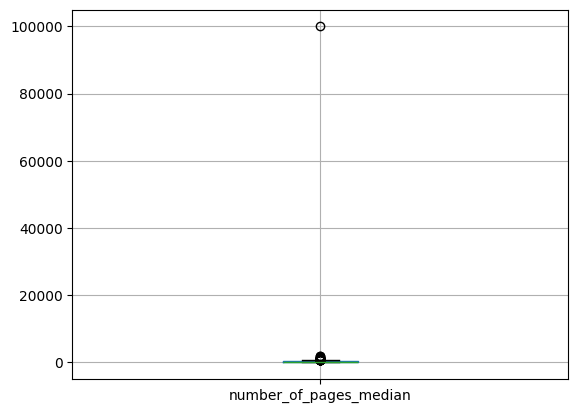

In [31]:
# Outliers
#fig, axes = plt.subplots(2, 2, figsize=(15, 5))
#fig.suptitle('Numerical Feature Boxplots')
data_df[['number_of_pages_median']].boxplot()
#axes[0].set_title('number_of_pages_median')
#data_df[['ratings_average']].boxplot()
#axes[1].set_title('ratings_average')
#data_df[['ratings_count']].boxplot()
#axes[2].set_title('ratings_count')
#data_df[['readinglog_count']].boxplot()
#axes[3].set_title('readinglog_count')
#data_df[['want_to_read_count']].boxplot()
#axes[4].set_title('want_to_read_count')
#data_df[['currently_reading_count']].boxplot()
#axes[5].set_title('currently_reading_count')
#data_df[['already_read_count']].boxplot()
#axes[6].set_title('already_read_count')


#'number_of_pages_median,publisher,format,subject,ratings_average,ratings_sortable,ratings_count,readinglog_count,want_to_read_count,currently_reading_count,already_read_count,first_sentence',


In [20]:
# Scale numerical Features

# Numerical columns
data_df[['first_publish_year','number_of_pages_median','ratings_average','ratings_sortable','ratings_count','readinglog_count','want_to_read_count','currently_reading_count','already_read_count']]
    


,first_publish_year,number_of_pages_median,ratings_average,ratings_sortable,ratings_count,readinglog_count,want_to_read_count,currently_reading_count,already_read_count
0,2019,NaN,NaN,NaN,NaN,1,1,0,0
1,2019,218.0,NaN,NaN,NaN,1,1,0,0
2,2019,654.0,NaN,NaN,NaN,3,3,0,0
3,2019,224.0,NaN,NaN,NaN,1,1,0,0
4,2019,NaN,NaN,NaN,NaN,2,2,0,0
...,...,...,...,...,...,...,...,...,...
995,2019,NaN,NaN,NaN,NaN,1,0,1,0
996,2019,NaN,NaN,NaN,NaN,1,1,0,0
997,2019,108.0,NaN,NaN,NaN,4,4,0,0
998,2019,NaN,NaN,NaN,NaN,1,1,0,0


Moving forward, let's first consider each of the following separately: 
1. What book features influence reading count from readers?
2. What book features positively influence ratings from readers?
3. How do these features impact ratings_sortable? A feature that combines and weighs the ratings outcome by the number of ratings?

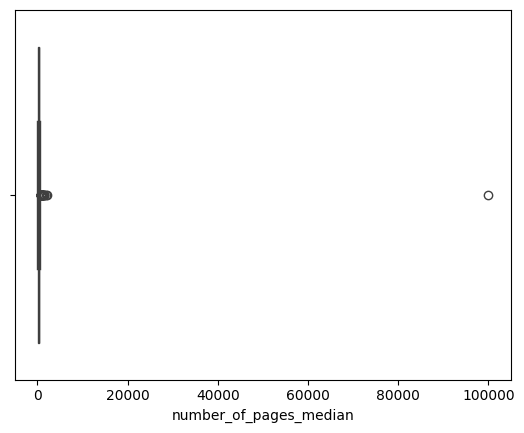

In [35]:
# Target col is readinglog_count = y
# Scale numerical features
import seaborn as sns
#sns.histplot(data_df[['number_of_pages_median']], bins=200,kde = True);
sns.boxplot(data=data_df, x='number_of_pages_median');
#data_df[['number_of_pages_median']]

In [48]:
# let's try some feature engineering
import numpy as np

np.min(data_df['number_of_pages_median'])
#data_df[['log_no_pages_med']] = np.log(data_df[['number_of_pages_median']])

#IMPOSSIBLE TO HAVE NEGATIVE PAGES - get rid of rows that have <1 pages

# Save the indexes corresponding to rows 
# without the absurd -1 value
boolean_mask = (data_df['number_of_pages_median']>0)

# Apply the boolean filtering
data_df = data_df[boolean_mask].reset_index(drop=True)

data_df.sort_values('number_of_pages_median', ascending=False)

,author_name,first_publish_year,language,publisher,title,readinglog_count,want_to_read_count,currently_reading_count,already_read_count,format,number_of_pages_median,subject,ratings_average,ratings_sortable,ratings_count,first_sentence,title_author,log_no_pages_med
108,"[Allyn J. Washington, Michelle Boué]",2019,[eng],"[Pearson Canada, Pearson Education Canada]",MyLab Math with Pearson EText -- Standalone Ac...,3,3,0,0,NaN,642.825806,NaN,NaN,NaN,NaN,NaN,MyLab Math with Pearson EText -- Standalone Ac...,6.125927
52,[James J. Gross; Toni Schmader; Bridgette Mart...,2019,[eng],[W. W. Norton],Interactive Psychology,1,1,0,0,NaN,10.735484,"[Personality, Applied psychology, Social scien...",NaN,NaN,NaN,NaN,Interactive Psychology by ['James J. Gross; To...,2.097624
33,"[Matthew H. Edney, Mary Sponberg Pedley]",2019,[eng],[University of Chicago Press],History of Cartography,2,2,0,0,NaN,10.064516,"[Cartography, Encyclopedias, History, Cartogra...",NaN,NaN,NaN,NaN,"History of Cartography by ['Matthew H. Edney',...",2.037281
29,[Kirby W. Beard],2019,NaN,[McGraw-Hill Education],"Linden's Handbook of Batteries, Fifth Edition",4,3,1,0,[hardcover],7.070968,[Electric batteries],NaN,NaN,NaN,NaN,"Linden's Handbook of Batteries, Fifth Edition ...",1.712226
138,"[Roger Park, Richard Friedman]",2019,NaN,[Foundation Press],"Evidence, Cases and Materials",2,2,0,0,[hardcover],6.909677,"[Evidence (law), united states]",NaN,NaN,NaN,NaN,"Evidence, Cases and Materials by ['Roger Park'...",1.691314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,[T. J. Martinson],2019,[eng],[Flatiron Books],Reign of the Kingfisher,1,1,0,0,NaN,0.051613,NaN,NaN,NaN,NaN,NaN,Reign of the Kingfisher by ['T. J. Martinson'],-0.597003
31,[Brandy Colbert],2019,[eng],"[Little, Brown Books for Young Readers, Perfec...",The Only Black Girls in Town,18,16,2,0,"[audio cd, paperback]",0.051613,"[Children's fiction, Multiculturalism, fiction...",NaN,NaN,NaN,NaN,The Only Black Girls in Town by ['Brandy Colbe...,-0.597003
164,"[John C. Murphy, Tom Crutchfield]",2019,[eng],"[Primedia eLaunch LLC, Book Services US, JCM N...",Giant Snakes,1,1,0,0,NaN,0.038710,NaN,NaN,NaN,NaN,NaN,"Giant Snakes by ['John C. Murphy', 'Tom Crutch...",-0.613810
60,[Gjertrud Stenbrenden],2019,NaN,[Cambridge University Press],"Long-Vowel Shifts in English, c. 1050-1700",1,1,0,0,[paperback],0.012903,"[English language, vowels, English language, o...",NaN,NaN,NaN,NaN,"Long-Vowel Shifts in English, c. 1050-1700 by ...",-0.648297


In [46]:
np.min(data_df['number_of_pages_median'])

np.float64(-0.7161290322580646)

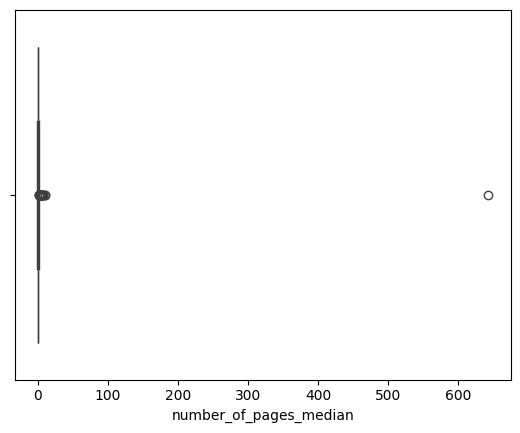

In [45]:
sns.boxplot(data=data_df, x='number_of_pages_median');

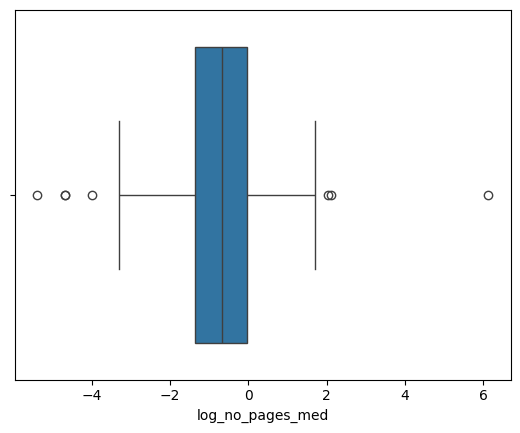

In [44]:
sns.boxplot(data=data_df, x='log_no_pages_med');

In [43]:
from sklearn.preprocessing import RobustScaler

# Step 0 - Instantiate Robust Scaler

rb_scaler = RobustScaler() 

# Step 1 - Fit the scaler to the 'number_of_pages_median'
# to "learn" the median value and the IQR

rb_scaler.fit(data_df[['number_of_pages_median']])

# Step 2 - Scale / Transform
# to apply the transformation (value - median) / IQR for every house

#data['GrLivArea'] = rb_scaler.transform(data[['GrLivArea']]) 
data_df['number_of_pages_median'] = rb_scaler.transform(data_df[['number_of_pages_median']])

data_df.head()

,author_name,first_publish_year,language,publisher,title,readinglog_count,want_to_read_count,currently_reading_count,already_read_count,format,number_of_pages_median,subject,ratings_average,ratings_sortable,ratings_count,first_sentence,title_author,log_no_pages_med
0,[Nanddeep Nachan],2019,[eng],"[Bpb Publications, BPB Publications]",Mastering Sharepoint Framework,3,3,0,0,NaN,1.896774,NaN,NaN,NaN,NaN,NaN,Mastering Sharepoint Framework by ['Nanddeep N...,0.621858
1,"[Michael H. Valentine, Keith Barker]",2019,[eng],"[Pearson, Pearson Education, Limited, Pearson ...",CCENT ICND1 100-101 Exam Cram,1,1,0,0,[paperback],1.083871,"[Cisco ios, Electronic data processing personn...",NaN,NaN,NaN,NaN,CCENT ICND1 100-101 Exam Cram by ['Michael H. ...,0.250295
2,"[Valerio De Oliveira Mazzuoli, Héctor Tulio Ba...",2019,NaN,[J.M. BOSCH EDITOR],Derecho internacional público contemporáneo,1,1,0,0,[paperback],4.645161,NaN,NaN,NaN,NaN,NaN,Derecho internacional público contemporáneo by...,1.339337
3,"[Julien Chevallier, Stéphane Goutte, David Gue...",2019,[eng],"[Routledge, Taylor & Francis Group]",International Financial Markets,2,1,1,0,[Paperback; Hardcover],0.470968,"[Econometrics, Mathematical modelling, Statist...",NaN,NaN,NaN,NaN,International Financial Markets by ['Julien Ch...,-0.164139
4,"[Jennifer Campbell, Barbara Clemens, Steven Fr...",2019,[eng],"[Cengage Learning, Course Technology]",Technology for Success,22,20,1,1,NaN,0.903226,"[Computer science, Microsoft office (computer ...",3.0,2.064538,2.0,NaN,Technology for Success by ['Jennifer Campbell'...,0.144934


In [51]:
# Categorical columns
x = data_df[['author_name', 'title', 'language', 'publisher', 'subject']]
y = data_df[['readinglog_count']]

,author_name,title,language,publisher,subject
0,[Nanddeep Nachan],Mastering Sharepoint Framework,[eng],"[Bpb Publications, BPB Publications]",NaN
1,"[Michael H. Valentine, Keith Barker]",CCENT ICND1 100-101 Exam Cram,[eng],"[Pearson, Pearson Education, Limited, Pearson ...","[Cisco ios, Electronic data processing personn..."
2,"[Valerio De Oliveira Mazzuoli, Héctor Tulio Ba...",Derecho internacional público contemporáneo,NaN,[J.M. BOSCH EDITOR],NaN
3,"[Julien Chevallier, Stéphane Goutte, David Gue...",International Financial Markets,[eng],"[Routledge, Taylor & Francis Group]","[Econometrics, Mathematical modelling, Statist..."
4,"[Jennifer Campbell, Barbara Clemens, Steven Fr...",Technology for Success,[eng],"[Cengage Learning, Course Technology]","[Computer science, Microsoft office (computer ..."
...,...,...,...,...,...
171,[GLORIA STEINEM],Outrageous Acts and Everyday Rebellions,NaN,[Picador],"[Feminists, Biography, Feminism]"
172,"[Ulrich Schubert, Nicola H�sing]",Synthesis of Inorganic Materials,[eng],"[Wiley & Sons, Incorporated, John]",NaN
173,[Suzanne Woods Fisher],Mending Fences,NaN,"[Revell, Thorndike Press Large Print]","[Fiction, christian, general, Fiction, family ..."
174,"[Kerri Maniscalco, Nicola Barber]",Capturing the Devil,[eng],"[Jimmy Patterson, JIMMY Patterson Books, an im...",[Children's fiction]


In [67]:
# Enrich language column to reduce amnt of NaN

# current list of all languages:

unique_langs=['eng']
#cycle through df and add any strings that are not already in the final list
def check_lang(row):
    if isinstance(row['language'], list):
        for lang in row['language']:
            if lang not in unique_langs:
                unique_langs.append(lang)
# for each row
data_df.apply(check_lang, axis=1)

print(unique_langs)


['eng', 'por', 'ger', 'spa']


In [97]:
# Fill in missing languages:
import langid

# langid provides language in  ISO 639-1 whereas OpenLib appears to provide language in ISO 639-3 format
# Here is an ISO 639-1 to ISO 639-3 Mapping Dictionary:
iso639_1_to_3 = {
    'af': 'afr',  # Afrikaans
    'sq': 'sqi',  # Albanian
    'ar': 'ara',  # Arabic
    'hy': 'hye',  # Armenian
    'bn': 'ben',  # Bengali
    'bs': 'bos',  # Bosnian
    'ca': 'cat',  # Catalan
    'hr': 'hrv',  # Croatian
    'cs': 'ces',  # Czech
    'da': 'dan',  # Danish
    'nl': 'nld',  # Dutch
    'en': 'eng',  # English
    'eo': 'epo',  # Esperanto
    'et': 'est',  # Estonian
    'fi': 'fin',  # Finnish
    'fr': 'fra',  # French
    'de': 'deu',  # German
    'el': 'ell',  # Greek
    'gu': 'guj',  # Gujarati
    'he': 'heb',  # Hebrew
    'hi': 'hin',  # Hindi
    'hu': 'hun',  # Hungarian
    'is': 'isl',  # Icelandic
    'id': 'ind',  # Indonesian
    'it': 'ita',  # Italian
    'ja': 'jpn',  # Japanese
    'jw': 'jav',  # Javanese
    'kn': 'kan',  # Kannada
    'km': 'khm',  # Khmer
    'ko': 'kor',  # Korean
    'la': 'lat',  # Latin
    'lv': 'lav',  # Latvian
    'lt': 'lit',  # Lithuanian
    'mk': 'mkd',  # Macedonian
    'ml': 'mal',  # Malayalam
    'mn': 'mon',  # Mongolian
    'mr': 'mar',  # Marathi
    'my': 'mya',  # Burmese
    'ne': 'nep',  # Nepali
    'no': 'nor',  # Norwegian
    'or': 'ori',  # Odia
    'pa': 'pan',  # Punjabi
    'pl': 'pol',  # Polish
    'ps': 'pus',  # Pashto
    'pt': 'por',  # Portuguese
    'pa': 'pan',  # Punjabi
    'ro': 'ron',  # Romanian
    'ru': 'rus',  # Russian
    'sa': 'san',  # Sanskrit
    'sd': 'snd',  # Sindhi
    'si': 'sin',  # Sinhala
    'sk': 'slk',  # Slovak
    'sl': 'slv',  # Slovenian
    'es': 'spa',  # Spanish
    'su': 'sun',  # Sundanese
    'sw': 'swa',  # Swahili
    'sv': 'swe',  # Swedish
    'ta': 'tam',  # Tamil
    'te': 'tel',  # Telugu
    'th': 'tha',  # Thai
    'tr': 'tur',  # Turkish
    'uk': 'ukr',  # Ukrainian
    'ur': 'udm',  # Urdu
    'vi': 'vie',  # Vietnamese
    'cy': 'cym',  # Welsh
    'xh': 'xho',  # Xhosa
    'yi': 'yid',  # Yiddish
    'yo': 'yor',  # Yoruba
    'zu': 'zul'   # Zulu
}

# Function to Identify and Convert Language Codes
def convert_language_code(code):
    # Check if the code is in ISO 639-1
    if len(code) == 2 and code.isalpha():
        # Convert ISO 639-1 to ISO 639-3
        return iso639_1_to_3.get(code, code)
    elif len(code) == 3 and code.isalpha():
        # It's already in ISO 639-3
        return code
    else:
        # Invalid or unknown code
        return None

# Function to identify and add language for NaN values under 'language'
def add_lang(row):
    # For all columns with NaN
    if (not (isinstance(row['language'], list))) and pd.isna(row['language']):
        print(row['language'])
        # Check language of title
        newlang, _ = langid.classify(row['title'])
        print(f"{row['title']} is in {newlang}")
        # Convert language into ISO 639-3
        insert_lang = convert_language_code(newlang)
        print(f"{newlang} is now {insert_lang}")
        # Insert language into list
        row['language'] = [insert_lang]
        # Add to unique languages list
        #check_lang(row['language'])
    return row

data_df = data_df.apply(add_lang, axis=1)


In [88]:
data_df.isna().sum() / len(data_df)

author_name                0.005682
first_publish_year         0.000000
language                   0.000000
publisher                  0.000000
title                      0.000000
readinglog_count           0.000000
want_to_read_count         0.000000
currently_reading_count    0.000000
already_read_count         0.000000
format                     0.426136
number_of_pages_median     0.000000
subject                    0.454545
ratings_average            0.886364
ratings_sortable           0.886364
ratings_count              0.886364
first_sentence             1.000000
title_author               0.000000
log_no_pages_med           0.000000
dtype: float64

In [98]:
# Subject
data_df[['subject']]

,subject
0,NaN
1,"[Cisco ios, Electronic data processing personn..."
2,NaN
3,"[Econometrics, Mathematical modelling, Statist..."
4,"[Computer science, Microsoft office (computer ..."
...,...
171,"[Feminists, Biography, Feminism]"
172,NaN
173,"[Fiction, christian, general, Fiction, family ..."
174,[Children's fiction]


In [ ]:
import seaborn as sns

# Correlation
sns.heatmap(round(data_df.corr(),2), ax=axes[0], cmap = "coolwarm", annot = True)
axes[0].set_title('Correlation of numeric cols')